In [221]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [2]:
os.getcwd()

'/Users/gabrieltorga/DataspellProjects'

In [71]:
# df = pd.read_table('Challege-Data-V2.tsv')
df = pd.read_csv('Challege-Data-V2.tsv', sep='\t')
# df = pd.read_csv('Challege-Data-V2.tsv', sep='\t',  converters={'waterfall_result': literal_eval})


In [72]:
df.head(5)

,event_id,event_time,app_id,platform,country,user_id,adtype,connection_type,device,session_id,waterfall_id,lifecycle_counter,waterfall_result
0,0f46e96e-927d-4dbb-b3ed-ec369b590b6e,2023-09-25 01:01:40.371000,1667250886,ios,US,1470652441,itt,wifi,"{""type"":""phone"",""model"":""iPhone14,8"",""w"":1284,...",2019e503-aa93-4981-a227-97df8aba5244,2196,1,"[{""id"":""4717"",""partner"":""AdMob"",""ecpm"":107.8,""..."
1,02ff7776-6fc0-4703-b156-2a2ff1fbce51,2023-09-25 01:01:37.363000,1667250886,ios,US,1301174730,itt,wifi,"{""type"":""phone"",""model"":""iPhone11,8"",""w"":828,""...",988f5138-ecce-4157-a384-2061fb30d651,2250,1,"[{""id"":""4715"",""partner"":""Chartboost"",""ecpm"":10..."
2,c0027e65-59db-4188-940d-d6aa71a74ff5,2023-09-25 01:00:55.767000,1667250886,ios,US,1557205304,itt,wifi,"{""type"":""phone"",""model"":""iPhone12,5"",""w"":1242,...",73ced24a-12ce-4dde-a0e9-03e1de9e569a,2250,1,"[{""id"":""4715"",""partner"":""Chartboost"",""ecpm"":10..."
3,0b4d0ba6-fba7-4a77-9a82-804d8403012c,2023-09-25 01:01:05.237000,1667250886,ios,US,1234667645,itt,wifi,"{""type"":""phone"",""model"":""iPhone12,1"",""w"":828,""...",7414053b-6730-4b62-97df-60ecac79ca43,2250,1,"[{""id"":""4715"",""partner"":""Chartboost"",""ecpm"":10..."
4,a76a1287-639f-4df5-a40b-70d9edfe330e,2023-09-25 01:01:07.169000,1667250886,ios,US,2048965824,itt,wifi,"{""type"":""phone"",""model"":""iPhone15,2"",""w"":1179,...",cb19eecd-d5bd-4089-b73c-81dfd6b58215,2250,1,"[{""id"":""4715"",""partner"":""Chartboost"",""ecpm"":10..."


In [73]:
df.size

1656044

#### Processing device data

In [74]:
df['device'] = df['device'].apply(lambda x: eval(x))
dfdevice = pd.json_normalize(df['device'])
dfdevice.rename(columns={'type':'device_type', 'model':'device_model', 'w':'device_w', 'h':'device_h', 'memory_total':'device_memory'},
                inplace=True)
df = pd.concat([df.drop(['device'], axis=1), dfdevice], axis=1)
df['device_model'] = df['device_model'].str.extract('(\d+)')
df['device_model'] = df['device_model'].astype(str).astype(int)

#### **Understanding waterfall logic**

In [75]:
print(df[:1]['waterfall_result'])
print(type(df[:1]['waterfall_result']))

0    [{"id":"4717","partner":"AdMob","ecpm":107.8,"...
Name: waterfall_result, dtype: object
<class 'pandas.core.series.Series'>


In [76]:
for i in df[:1]['waterfall_result']:
    for item in eval(i):
        print(item)
        print(type(item))

{'id': '4717', 'partner': 'AdMob', 'ecpm': 107.8, 'latency': 1088, 'error': '1'}
<class 'dict'>
{'id': '4715', 'partner': 'Chartboost', 'ecpm': 100.0, 'latency': 60, 'error': '3'}
<class 'dict'>
{'id': '4156', 'partner': 'AppLovin', 'ecpm': 86.0, 'latency': 914, 'error': '204'}
<class 'dict'>
{'id': '4723', 'partner': 'DFP', 'ecpm': 83.09, 'latency': 611, 'error': '1'}
<class 'dict'>
{'id': '4724', 'partner': 'IronSource', 'ecpm': 83.0, 'latency': 715, 'error': '0'}
<class 'dict'>
{'id': '4726', 'partner': 'Unity', 'ecpm': 81.0, 'latency': 1296, 'error': '3'}
<class 'dict'>
{'id': '4720', 'partner': 'Vungle', 'ecpm': 80.75, 'latency': 345, 'error': '-119999'}
<class 'dict'>
{'id': '4730', 'partner': 'Chartboost', 'ecpm': 79.0, 'latency': 43, 'error': '3'}
<class 'dict'>
{'id': '4728', 'partner': 'Vungle', 'ecpm': 76.0, 'latency': 0, 'error': '13'}
<class 'dict'>
{'id': '9823', 'partner': 'Makroo', 'ecpm': 75.0, 'latency': 409, 'error': '1'}
<class 'dict'>
{'id': '4741', 'partner': 'Cha

#### Processing device data

In [77]:
df['waterfall_result'] = df['waterfall_result'].apply(json.loads)
# df['waterfall_result'] = df['waterfall_result'].apply(lambda x: eval(x))

In [78]:
for i in df[:1]['waterfall_result']:
    print(type(i))

<class 'list'>


In [79]:
df = df.explode('waterfall_result').reset_index(drop=True)
dfwaterfalls = pd.json_normalize(df['waterfall_result'])
dfwaterfalls.rename(columns={'id':'instance_id', 'error':'instance_error'},
                    inplace=True)
df = pd.concat([df.drop(['waterfall_result'], axis=1), dfwaterfalls], axis=1)

#### Adding target

In [91]:
df['instance_error'] = np.where(df['instance_error'].isnull(), 1, 0)
df.rename(columns={'instance_error':'target'}, inplace=True)

#### **Exploring the dataset**


In [80]:
df.describe()
# Unique: app_id, user_id, waterfall_id

,app_id,user_id,waterfall_id,lifecycle_counter,device_model,device_w,device_h,device_memory,ecpm,latency
count,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06,5.516622e+06
mean,1.667251e+09,1.066500e+09,2.245274e+03,4.085091e+00,1.275968e+01,1.157663e+03,2.345122e+03,4.312215e+03,3.639513e+01,4.799606e+02
std,0.000000e+00,6.263451e+08,5.260740e+01,5.692902e+00,1.951448e+00,2.369436e+02,4.141654e+02,1.249446e+03,2.410781e+01,1.056863e+04
min,1.667251e+09,1.930050e+05,2.196000e+03,1.000000e+00,4.000000e+00,6.400000e+02,1.136000e+03,9.690000e+02,4.750000e-02,0.000000e+00
25%,1.667251e+09,5.199652e+08,2.196000e+03,1.000000e+00,1.200000e+01,1.080000e+03,2.048000e+03,3.647000e+03,1.677760e+01,2.270000e+02
50%,1.667251e+09,1.063532e+09,2.196000e+03,2.000000e+00,1.300000e+01,1.170000e+03,2.532000e+03,3.851000e+03,3.100000e+01,3.770000e+02
75%,1.667251e+09,1.613505e+09,2.305000e+03,5.000000e+00,1.400000e+01,1.284000e+03,2.556000e+03,5.644000e+03,5.200000e+01,5.540000e+02
max,1.667251e+09,2.147431e+09,2.305000e+03,9.300000e+01,1.600000e+01,2.048000e+03,2.796000e+03,1.570100e+04,7.500000e+02,1.454181e+07


In [81]:
print(df.event_time.min())
print(df.event_time.max())

2023-09-25 00:00:02.570000
2023-10-01 23:59:55.587000


In [82]:
df.shape

(5516622, 22)

In [83]:
for i in list(df.columns):
    print(f'Distinct values for {i}: {df[i].nunique()}')

Distinct values for event_id: 127388
Distinct values for event_time: 127364
Distinct values for app_id: 1
Distinct values for platform: 1
Distinct values for country: 1
Distinct values for user_id: 14110
Distinct values for adtype: 1
Distinct values for connection_type: 5
Distinct values for session_id: 62103
Distinct values for waterfall_id: 3
Distinct values for lifecycle_counter: 93
Distinct values for device_type: 2
Distinct values for device_model: 13
Distinct values for device_w: 16
Distinct values for device_h: 18
Distinct values for device_memory: 166
Distinct values for instance_id: 282
Distinct values for partner: 23
Distinct values for ecpm: 18156
Distinct values for latency: 8880
Distinct values for instance_error: 62
Distinct values for auction_id: 40738


In [84]:
for i in list(df.columns):
    print(f'Nulls for {i}: {df[i].isnull().sum()}')

Nulls for event_id: 0
Nulls for event_time: 0
Nulls for app_id: 0
Nulls for platform: 0
Nulls for country: 0
Nulls for user_id: 0
Nulls for adtype: 0
Nulls for connection_type: 0
Nulls for session_id: 630
Nulls for waterfall_id: 0
Nulls for lifecycle_counter: 0
Nulls for device_type: 0
Nulls for device_model: 0
Nulls for device_w: 0
Nulls for device_h: 0
Nulls for device_memory: 0
Nulls for instance_id: 0
Nulls for partner: 0
Nulls for ecpm: 0
Nulls for latency: 0
Nulls for instance_error: 127388
Nulls for auction_id: 5475884


#### Checking distribution inside variables

In [85]:
df.connection_type.value_counts(normalize=True, dropna=False)

connection_type
wifi         0.804019
mobile_4g    0.101834
mobile_5g    0.094095
mobile_3g    0.000041
mobile_2g    0.000010
Name: proportion, dtype: float64

In [86]:
df.device_type.value_counts(normalize=True, dropna=False)

device_type
phone     0.89414
tablet    0.10586
Name: proportion, dtype: float64

In [87]:
df.device_model.value_counts(normalize=True, dropna=False)


device_model
14    0.337795
13    0.197955
12    0.184272
15    0.102999
11    0.079511
10    0.030317
7     0.021338
6     0.015319
8     0.010448
9     0.008521
16    0.005860
5     0.005116
4     0.000549
Name: proportion, dtype: float64

In [88]:
df.device_w.value_counts(normalize=True, dropna=False)

device_w
1170    0.330219
828     0.169073
1284    0.143605
1290    0.057147
750     0.053509
1179    0.051547
1080    0.040963
1620    0.034028
1536    0.033461
1125    0.025373
1242    0.021293
1640    0.020138
1668    0.010723
2048    0.006355
640     0.001412
1488    0.001154
Name: proportion, dtype: float64

In [89]:
df.device_h.value_counts(normalize=True, dropna=False)

device_h
2532    0.330219
1792    0.169073
2778    0.143605
2796    0.057147
1334    0.053509
2556    0.051547
2160    0.034028
2048    0.033461
2340    0.025517
2436    0.025373
2688    0.021293
2360    0.020138
1920    0.015447
2732    0.006355
2224    0.005941
2388    0.004783
1136    0.001412
2266    0.001154
Name: proportion, dtype: float64

In [133]:
df['ecpm'].quantile([0.25, 0.5, 0.75])

0.25    16.7776
0.50    31.0000
0.75    52.0000
Name: ecpm, dtype: float64

<Axes: xlabel='ecpm'>

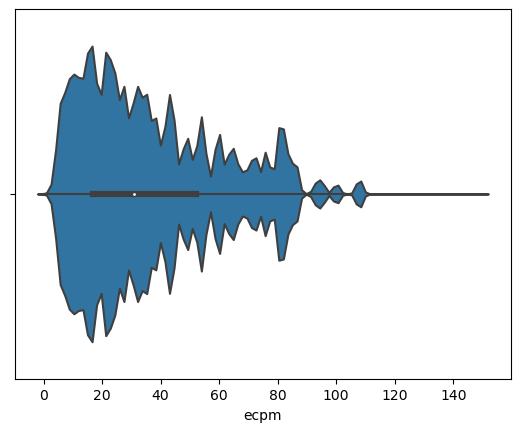

In [129]:
sns.violinplot(x=df[df['ecpm']<=150]["ecpm"])

<Axes: xlabel='ecpm', ylabel='Count'>

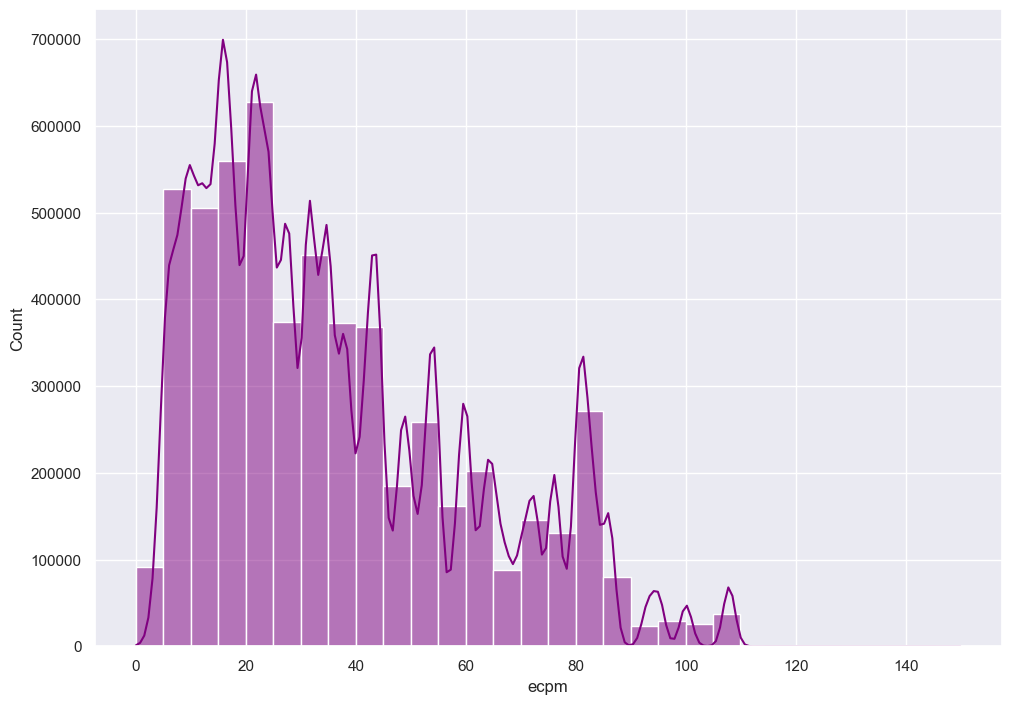

In [211]:
sns.histplot(df[df['ecpm']<=150]['ecpm'],kde=True,color='purple',bins=30)

<Axes: xlabel='ecpm', ylabel='partner'>

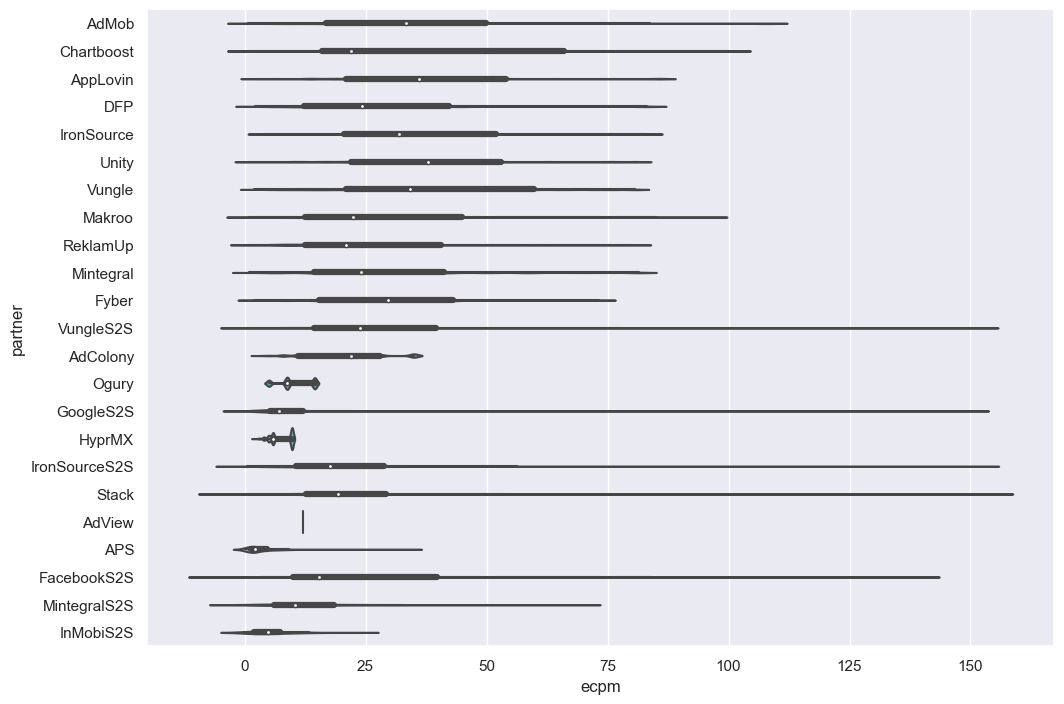

In [194]:
sns.violinplot(data=df, x=df[df['ecpm']<=150]["ecpm"], y="partner", height=8.27, aspect=11.7/8.27)

In [152]:
agg_funcs = {
    'event_id': ['count'],
    'ecpm': ['min', 'mean', 'max'],
    'target': lambda x: (x == 1).sum()
}


partners = df.groupby('partner').agg(agg_funcs).reset_index()
partners.columns = ['partner', 'n_instances', 'min_price', 'mean_price', 'max_price', 'target_1']
partners['fill_rate'] = (partners['target_1']/partners['n_instances']).astype(float)
partners

,partner,n_instances,min_price,mean_price,max_price,target_1,fill_rate
0,APS,555,0.047500,3.643293,34.200000,552,0.994595
1,AdColony,211940,3.000000,21.550200,35.000000,2029,0.009573
2,AdMob,423601,0.784000,39.447021,107.800000,4331,0.010224
3,AdView,2164,12.000000,12.000000,12.000000,0,0.000000
4,AppLovin,724091,2.210000,39.553510,86.000000,14725,0.020336
5,Chartboost,437368,1.000000,39.745099,100.000000,2695,0.006162
6,DFP,181693,2.140000,30.104907,83.090000,851,0.004684
7,FacebookS2S,1005,3.018059,34.831765,750.000000,873,0.868657
8,Fyber,198182,1.980000,33.221848,73.260000,806,0.004067
9,GoogleS2S,6446,1.162232,15.107484,642.409600,6403,0.993329


In [155]:
high_partners = partners[partners['fill_rate']>=0.5].partner.to_list()
high_partners

['APS',
 'FacebookS2S',
 'GoogleS2S',
 'InMobiS2S',
 'IronSourceS2S',
 'MintegralS2S',
 'Stack',
 'VungleS2S']

In [159]:
print('With all partners')
print(df.target.value_counts())
print(df.target.value_counts(normalize=True))

With all partners
target
0    5389234
1     127388
Name: count, dtype: int64
target
0    0.976908
1    0.023092
Name: proportion, dtype: float64


In [163]:
print('Without "high" partners')
print(df[~df['partner'].isin(high_partners)].target.value_counts())
print(df[~df['partner'].isin(high_partners)].target.value_counts(normalize=True))


Without "high" partners
target
0    5374872
1      97170
Name: count, dtype: int64
target
0    0.982242
1    0.017758
Name: proportion, dtype: float64


In [164]:
dfh = df[~df['partner'].isin(high_partners)]

In [200]:
dfh.lifecycle_counter.value_counts()

lifecycle_counter
1     2278565
2      839679
3      528029
4      382459
5      278605
       ...   
90         62
91         61
79         48
89         45
93         11
Name: count, Length: 93, dtype: int64

In [197]:
dfh.head()

,event_id,event_time,app_id,platform,country,user_id,adtype,connection_type,session_id,waterfall_id,...,device_model,device_w,device_h,device_memory,instance_id,partner,ecpm,latency,target,auction_id
0,0f46e96e-927d-4dbb-b3ed-ec369b590b6e,2023-09-25 01:01:40.371000,1667250886,ios,US,1470652441,itt,wifi,2019e503-aa93-4981-a227-97df8aba5244,2196,...,14,1284,2778,5668.0,4717,AdMob,107.80,1088,0,NaN
1,0f46e96e-927d-4dbb-b3ed-ec369b590b6e,2023-09-25 01:01:40.371000,1667250886,ios,US,1470652441,itt,wifi,2019e503-aa93-4981-a227-97df8aba5244,2196,...,14,1284,2778,5668.0,4715,Chartboost,100.00,60,0,NaN
2,0f46e96e-927d-4dbb-b3ed-ec369b590b6e,2023-09-25 01:01:40.371000,1667250886,ios,US,1470652441,itt,wifi,2019e503-aa93-4981-a227-97df8aba5244,2196,...,14,1284,2778,5668.0,4156,AppLovin,86.00,914,0,NaN
3,0f46e96e-927d-4dbb-b3ed-ec369b590b6e,2023-09-25 01:01:40.371000,1667250886,ios,US,1470652441,itt,wifi,2019e503-aa93-4981-a227-97df8aba5244,2196,...,14,1284,2778,5668.0,4723,DFP,83.09,611,0,NaN
4,0f46e96e-927d-4dbb-b3ed-ec369b590b6e,2023-09-25 01:01:40.371000,1667250886,ios,US,1470652441,itt,wifi,2019e503-aa93-4981-a227-97df8aba5244,2196,...,14,1284,2778,5668.0,4724,IronSource,83.00,715,0,NaN


In [201]:
dfinal = dfh[['connection_type', 'device_type', 'device_model', 'device_w', 'device_h', 'device_memory', 'ecpm', 'target']]

In [202]:
dfinal.dtypes

connection_type     object
device_type         object
device_model         int64
device_w             int64
device_h             int64
device_memory      float64
ecpm               float64
target               int64
dtype: object

In [203]:
#Categorical data
categorical_cols = ['connection_type', 'device_type']
dfcat = pd.get_dummies(dfinal, columns = categorical_cols, dtype=int)

In [212]:
dfcat.columns.tolist()

['device_model',
 'device_w',
 'device_h',
 'device_memory',
 'ecpm',
 'target',
 'connection_type_mobile_2g',
 'connection_type_mobile_3g',
 'connection_type_mobile_4g',
 'connection_type_mobile_5g',
 'connection_type_wifi',
 'device_type_phone',
 'device_type_tablet']

In [213]:
abs(pd.DataFrame(dfcat.corr().target))

,target
device_model,0.012789
device_w,0.000971
device_h,0.010560
device_memory,0.014217
ecpm,0.056237
target,1.000000
connection_type_mobile_2g,0.000010
connection_type_mobile_3g,0.000239
connection_type_mobile_4g,0.012614
connection_type_mobile_5g,0.014742


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Would remove:
    /Users/gabrieltorga/anaconda3/lib/python3.11/site-packages/scikit_learn-1.2.2.dist-info/*
    /Users/gabrieltorga/anaconda3/lib/python3.11/site-packages/sklearn/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
^C
ERROR: Operation cancelled by user


In [251]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/Users/gabrieltorga/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)

In [215]:
X = dfcat.drop(['target'], axis=1)
y = dfcat['target']

In [217]:
X.head(3)

,device_model,device_w,device_h,device_memory,ecpm,connection_type_mobile_2g,connection_type_mobile_3g,connection_type_mobile_4g,connection_type_mobile_5g,connection_type_wifi,device_type_phone,device_type_tablet
0,14,1284,2778,5668.0,107.8,0,0,0,0,1,1,0
1,14,1284,2778,5668.0,100.0,0,0,0,0,1,1,0
2,14,1284,2778,5668.0,86.0,0,0,0,0,1,1,0


In [218]:
y.head(2)

0    0
1    0
Name: target, dtype: int64

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

In [231]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3830429, 12)
X_test shape: (1641613, 12)
y_train shape: (3830429,)
y_test shape: (1641613,)


In [232]:
X_train.head(3)

,device_model,device_w,device_h,device_memory,ecpm,connection_type_mobile_2g,connection_type_mobile_3g,connection_type_mobile_4g,connection_type_mobile_5g,connection_type_wifi,device_type_phone,device_type_tablet
2327052,13,1284,2778,5667.0,69.00,0,0,0,0,1,1,0
613290,15,1290,2796,5618.0,25.65,0,0,0,0,1,1,0
2130775,13,1284,2778,5676.0,54.15,0,0,0,1,0,1,0
5453832,14,1080,2340,3660.0,22.00,0,0,0,0,1,1,0
3281782,15,1179,2556,5644.0,43.70,0,0,0,1,0,1,0
4151982,12,828,1792,3851.0,6.00,0,0,0,0,1,1,0
1395405,13,1284,2778,5676.0,11.00,0,0,0,0,1,1,0
3207873,13,1284,2778,5667.0,31.00,0,0,0,0,1,1,0
2707530,14,1170,2532,5652.0,83.00,0,0,0,0,1,1,0
3654538,14,1170,2532,5686.0,22.00,0,0,0,0,1,1,0


In [233]:
cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

In [244]:
X_train.head(3)

,device_model,device_w,device_h,device_memory,ecpm,connection_type_mobile_2g,connection_type_mobile_3g,connection_type_mobile_4g,connection_type_mobile_5g,connection_type_wifi,device_type_phone,device_type_tablet
0,0.0,0.558824,0.484252,0.909364,1.049075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.588235,0.519685,0.884827,-0.147699,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.558824,0.484252,0.913871,0.639107,0.0,0.0,0.0,1.0,-1.0,0.0,0.0


In [235]:
LogisticRegression_model = LogisticRegression(
    class_weight='balanced', 
    max_iter=4000)
LogisticRegression_model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=4000)

In [236]:
y_pred = LogisticRegression_model.predict(X_test)

In [237]:
confusion_matrix = confusion_matrix(y_test,y_pred)
confusion_matrix

array([[887273, 725314],
       [  9499,  19527]])

In [238]:
print('Accuracy: ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall: ', (metrics.recall_score(y_test, y_pred)))
print('Precision: ', (metrics.precision_score(y_test, y_pred)))


Accuracy:  0.5523835398476986
Recall:  0.6727416798732171
Precision:  0.02621633341881019


In [242]:
prediction_prob = LogisticRegression_model.predict_proba(X_test)[:,1]
prediction_prob[prediction_prob > 0.5] = 1
prediction_prob[prediction_prob <= 0.5] = 0
print(classification_report(y_test,prediction_prob))

              precision    recall  f1-score   support

           0       0.99      0.55      0.71   1612587
           1       0.03      0.67      0.05     29026

    accuracy                           0.55   1641613
   macro avg       0.51      0.61      0.38   1641613
weighted avg       0.97      0.55      0.70   1641613


In [183]:
dfcat.columns.tolist()

['lifecycle_counter',
 'device_model',
 'device_w',
 'device_h',
 'device_memory',
 'ecpm',
 'latency',
 'target',
 'connection_type_mobile_2g',
 'connection_type_mobile_3g',
 'connection_type_mobile_4g',
 'connection_type_mobile_5g',
 'connection_type_wifi',
 'device_type_phone',
 'device_type_tablet']

In [184]:
X = dfcat.drop(['target'], axis=1)
y = dfcat['target']

In [185]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1

Fold:1, Train set: 4377633, Test set:1094409
Fold:2, Train set: 4377633, Test set:1094409
Fold:3, Train set: 4377634, Test set:1094408
Fold:4, Train set: 4377634, Test set:1094408
Fold:5, Train set: 4377634, Test set:1094408


In [189]:
classifier = LogisticRegression(random_state= 42, solver='lbfgs', penalty='l2', max_iter=500)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [190]:
acc = cross_val_score(classifier, X, y, cv= kf, scoring="accuracy")
print(f'Accuracy for each fold: {acc}')
print(f'Average accuracy: {"{:.2f}".format(acc.mean())}')

Accuracy for each fold: [0.98224247 0.98223607 0.98224154 0.98224154 0.98224154]
Average accuracy: 0.98


In [191]:
recall = cross_val_score(classifier, X, y, cv= kf, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(classifier, X, y, cv= kf, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(classifier, X, y, cv= kf, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.0 [0. 0. 0. 0. 0.]


/Users/gabrieltorga/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision 0.0 [0. 0. 0. 0. 0.]
F1 0.0 [0. 0. 0. 0. 0.]
